In [1]:
%%capture
!sudo apt-get install -q -y xvfb ffmpeg freeglut3-dev
!pip install tf-agents[reverb]
!pip install gym
!pip install gym[atari]
!pip install gym[accept-rom-license]

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import PIL
import IPython
import base64
import imageio
import gym

from tf_agents.environments import suite_gym, tf_py_environment
from tf_agents.environments.atari_preprocessing import AtariPreprocessing
from tf_agents.environments.atari_wrappers import FrameStack4, AtariTimeLimit
from tf_agents.agents.dqn import dqn_agent
from tf_agents.specs import tensor_spec
from tf_agents.networks import sequential
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.drivers.dynamic_step_driver import DynamicStepDriver
from tf_agents.metrics import tf_metrics
from tf_agents.utils import common

In [24]:
num_iterations = 80000

initial_collect_steps = 500
collect_steps_per_iteration = 1
replay_buffer_max_length = 100000

batch_size = 64
learning_rate = 1e-3

log_interval = 1000
eval_interval = 1000

# create environment

In [25]:
env_ids = [env_spec.id for env_spec in gym.envs.registry.all()]
all_env_ids = sorted(env_ids)

In [26]:
env_name = 'ALE/Freeway-v5'
max_episode_steps = 27000

train_py_env = suite_gym.wrap_env(
    gym.make(env_name, frameskip=1),
    max_episode_steps=max_episode_steps,
    gym_env_wrappers=[AtariPreprocessing, FrameStack4],
    time_limit_wrapper=AtariTimeLimit
)
eval_py_env = suite_gym.wrap_env(
    gym.make(env_name, frameskip=1),
    max_episode_steps=max_episode_steps,
    gym_env_wrappers=[AtariPreprocessing, FrameStack4],
    time_limit_wrapper=AtariTimeLimit
)

In [27]:
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

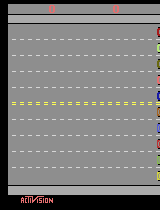

In [28]:
train_py_env.reset()
PIL.Image.fromarray(train_py_env.render())

In [29]:
train_py_env.action_spec()

BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=2)

# define DQN agent

In [30]:
action_tensor_spec = tensor_spec.from_spec(train_env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

conv_kwargs = dict(
    kernel_size=3,
    padding='same',
    kernel_initializer='he_normal',
    activation='relu'
)

q_net = sequential.Sequential([
    tf.keras.layers.Rescaling(scale=1./255),
    tf.keras.layers.Conv2D(32, **conv_kwargs),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, **conv_kwargs),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, **conv_kwargs),
    tf.keras.layers.GlobalMaxPooling2D(),
    tf.keras.layers.Dense(num_actions)
])

In [31]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
epsilon_fn = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=0.7,
    decay_steps=num_iterations//3//collect_steps_per_iteration,
    end_learning_rate=0.01)
train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    train_step_counter=train_step_counter,
    epsilon_greedy=lambda: epsilon_fn(train_step_counter)
)

agent.initialize()

# policy

In [32]:
eval_policy = agent.policy
collect_policy = agent.collect_policy

In [33]:
random_policy = random_tf_policy.RandomTFPolicy(
    train_env.time_step_spec(),
    train_env.action_spec()
)

# replay buffer

In [34]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length
)

In [35]:
rb_observer = replay_buffer.add_batch
avg_return = tf_metrics.AverageReturnMetric()

In [36]:
_ = DynamicStepDriver(
    train_env,
    random_policy,
    [rb_observer, avg_return],
    num_steps=initial_collect_steps
).run()

In [37]:
avg_return.result().numpy()

0.0

In [38]:
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2,
    single_deterministic_pass=False
).prefetch(3)

In [39]:
iterator = iter(dataset)

# train

In [40]:
agent.train = common.function(agent.train)
agent.train_step_counter.assign(0)

collect_driver = DynamicStepDriver(
    train_env,
    agent.collect_policy,
    [rb_observer, avg_return],
    num_steps=collect_steps_per_iteration
)
collect_driver.run = common.function(collect_driver.run)

In [41]:
returns = []
time_step = train_env.reset()

for _ in range(num_iterations):
    time_step, _ = collect_driver.run(time_step)

    experience, unused_info = next(iterator)
    train_loss = agent.train(experience).loss

    step = agent.train_step_counter.numpy()

    if step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss))

    if step % eval_interval == 0:
        avgr = avg_return.result().numpy()
        print('step = {0}: average return = {1}'.format(step, avgr))
        returns.append(avgr)

step = 1000: loss = 7604972.0
step = 1000: average return = 0.0
step = 2000: loss = 107376256.0
step = 2000: average return = 0.0
step = 3000: loss = 347540352.0
step = 3000: average return = 0.0
step = 4000: loss = 690920704.0
step = 4000: average return = 0.0
step = 5000: loss = 1464140800.0
step = 5000: average return = 0.5
step = 6000: loss = 2232023040.0
step = 6000: average return = 0.5
step = 7000: loss = 21321779200.0
step = 7000: average return = 1.0
step = 8000: loss = 4973664256.0
step = 8000: average return = 1.0
step = 9000: loss = 6512181248.0
step = 9000: average return = 1.25
step = 10000: loss = 7936745472.0
step = 10000: average return = 1.25
step = 11000: loss = 9742688256.0
step = 11000: average return = 1.2000000476837158
step = 12000: loss = 16028581888.0
step = 12000: average return = 1.2000000476837158
step = 13000: loss = 20767465472.0
step = 13000: average return = 1.1666666269302368
step = 14000: loss = 22254166016.0
step = 14000: average return = 1.166666626

In [42]:
avg_return.result().numpy()

16.8

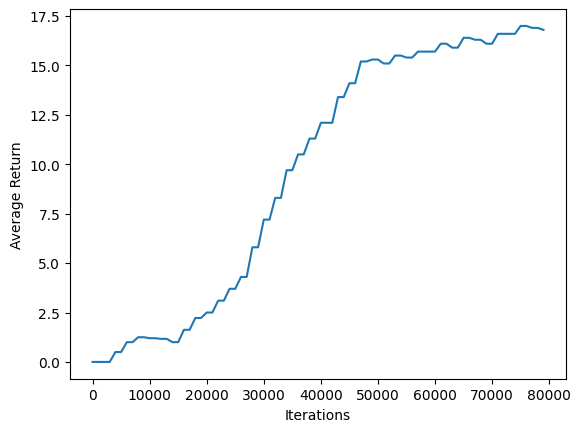

In [43]:
iterations = range(0, num_iterations, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations');

# watch the agent play

In [47]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename, 'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

In [48]:
def create_policy_eval_video(policy, filename, num_episodes=1, fps=30):
  filename = filename + '.mp4'
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      time_step = eval_env.reset()
      video.append_data(eval_env.render().numpy().squeeze())
      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step.action)
        video.append_data(eval_env.render().numpy().squeeze())
  return embed_mp4(filename)

In [49]:
create_policy_eval_video(agent.policy, 'trained_agent')